# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

In [1]:
%pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ydata_profiling import ProfileReport
import pandas as pd
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('/datasets/hotel_train.csv',index_col='id')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65229 entries, 0 to 84121
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_year               65229 non-null  int64  
 3   arrival_date_month              65229 non-null  object 
 4   arrival_date_week_number        65229 non-null  int64  
 5   arrival_date_day_of_month       65229 non-null  int64  
 6   stays_in_weekend_nights         65229 non-null  int64  
 7   stays_in_week_nights            65229 non-null  int64  
 8   adults                          65229 non-null  float64
 9   children                        65229 non-null  float64
 10  babies                          65229 non-null  float64
 11  meal                            65229 non-null  object 
 12  country                         

In [ ]:
ProfileReport(df)

#### Вывод

Количество объектов: 65 229<br/>
Отсутствуют пропуски в столбцах<br/>
Признаки:<br/>
id — номер записи;<br/>
adults — количество взрослых постояльцев;<br/>
arrival_date_year — год заезда;<br/>
arrival_date_month — месяц заезда;<br/>
arrival_date_week_number — неделя заезда;<br/>
arrival_date_day_of_month — день заезда;<br/>
babies — количество младенцев;<br/>
booking_changes — количество изменений параметров заказа;<br/>
children — количество детей от 3 до 14 лет;<br/>
country — гражданство постояльца;<br/>
customer_type — тип заказчика:<br/>
Contract — договор с юридическим лицом;<br/>
Group — групповой заезд;<br/>
Transient — не связано с договором или групповым заездом;<br/>
Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.<br/>
days_in_waiting_list — сколько дней заказ ожидал подтверждения;<br/>
distribution_channel — канал дистрибуции заказа;<br/>
is_canceled — отмена заказа;<br/>
is_repeated_guest — признак того, что гость бронирует номер второй раз;<br/>
lead_time — количество дней между датой бронирования и датой прибытия;<br/>
meal — опции заказа:<br/>
SC — нет дополнительных опций;<br/>
BB — включён завтрак;<br/>
HB — включён завтрак и обед;<br/>
FB — включён завтрак, обед и ужин.<br/>
previous_bookings_not_canceled — количество подтверждённых заказов у клиента;<br/>
previous_cancellations — количество отменённых заказов у клиента;<br/>
required_car_parking_spaces — необходимость места для автомобиля;<br/>
reserved_room_type — тип забронированной комнаты;<br/>
stays_in_weekend_nights — количество ночей в выходные дни;<br/>
stays_in_week_nights — количество ночей в будние дни;<br/>
total_nights — общее количество ночей;<br/>
total_of_special_requests — количество специальных отметок.<br/>
Целевой признак:is_canceled<br/>

### Шаг 2. Предобработка и исследовательский анализ данных

In [6]:
df.loc[df.duplicated()]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
id,,,,,,,,,,,,,,,,,,,,,
13,0,72.0,2015,July,27,1,2,4,2.0,0.0,...,0,0,0,A,1,0,Transient,0,1,6
87,1,5.0,2015,July,28,5,1,0,2.0,0.0,...,0,0,0,D,0,0,Transient,0,0,1
118,0,0.0,2015,July,28,7,0,1,1.0,0.0,...,0,0,0,A,0,0,Transient,0,3,1
130,1,1.0,2015,July,28,8,0,1,2.0,0.0,...,0,0,0,A,0,0,Transient,0,1,1
224,0,40.0,2015,July,29,13,1,4,2.0,0.0,...,0,0,0,D,0,0,Transient,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83965,0,269.0,2016,December,53,29,2,3,1.0,0.0,...,0,0,0,A,0,0,Transient-Party,0,0,5
83966,0,269.0,2016,December,53,29,2,3,1.0,0.0,...,0,0,0,A,0,0,Transient-Party,0,0,5
83969,0,269.0,2016,December,53,29,2,3,1.0,0.0,...,0,0,0,A,0,0,Transient-Party,0,0,5


In [7]:
df = df.drop_duplicates()

In [8]:
df = df.reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43852 entries, 0 to 43851
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     43852 non-null  int64  
 1   lead_time                       43852 non-null  float64
 2   arrival_date_year               43852 non-null  int64  
 3   arrival_date_month              43852 non-null  object 
 4   arrival_date_week_number        43852 non-null  int64  
 5   arrival_date_day_of_month       43852 non-null  int64  
 6   stays_in_weekend_nights         43852 non-null  int64  
 7   stays_in_week_nights            43852 non-null  int64  
 8   adults                          43852 non-null  float64
 9   children                        43852 non-null  float64
 10  babies                          43852 non-null  float64
 11  meal                            43852 non-null  object 
 12  country                         

In [10]:
df['reserved_room_type']= df['reserved_room_type'].str.strip()
df['country']= df['country'].str.strip()

In [11]:
df['adults'].mean()

1.8562893368603484

In [12]:
df.query('adults == 0')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
13828,0,1.0,2015,August,33,10,1,1,0.0,3.0,...,0,0,0,B,1,0,Transient-Party,0,0,2
13879,0,104.0,2015,August,33,11,0,3,0.0,2.0,...,0,0,0,B,1,0,Transient-Party,0,2,3
14016,0,3.0,2015,August,34,16,2,0,0.0,2.0,...,0,0,0,B,1,0,Transient-Party,0,1,2
15641,1,48.0,2015,October,43,19,1,3,0.0,2.0,...,0,0,0,B,0,0,Transient-Party,0,1,4
15960,1,6.0,2015,December,51,13,1,0,0.0,3.0,...,0,0,0,B,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43455,0,197.0,2016,December,52,21,1,4,0.0,3.0,...,0,0,0,A,7,0,Transient-Party,0,0,5
43563,0,104.0,2016,December,53,25,2,1,0.0,2.0,...,0,0,0,B,1,0,Transient,0,2,3
43571,0,104.0,2016,December,53,25,2,1,0.0,2.0,...,0,0,0,B,0,0,Transient,0,2,3
43580,0,247.0,2016,December,52,24,2,3,0.0,2.0,...,0,0,0,B,0,0,Transient,0,1,5


In [13]:
df['adults'] = df['adults'].replace(0,df['adults'].median())

In [14]:
df['adults'].mean()

1.8637690413208063

In [15]:
df['previous_cancellations'].value_counts()

0     42701
1       995
2        52
3        47
11       27
5        13
4         5
13        3
6         2
24        2
14        1
19        1
21        1
25        1
26        1
Name: previous_cancellations, dtype: int64

In [16]:
len(df.query('previous_cancellations > 1'))

156

In [17]:
df.query('previous_cancellations > 1').describe().compare(df.query('previous_cancellations <= 1').describe())

is_canceled                 lead_time               arrival_date_year  \
             self         other        self         other              self   
count  156.000000  43696.000000  156.000000  43696.000000        156.000000   
mean     0.314103      0.254005   53.115385     67.946540       2015.807692   
std      0.465652      0.435305   91.159906     73.918267          0.395383   
min           NaN           NaN         NaN           NaN               NaN   
25%           NaN           NaN    2.000000      9.000000               NaN   
50%           NaN           NaN    6.000000     41.000000               NaN   
75%           NaN           NaN   38.750000    103.000000               NaN   
max           NaN           NaN  355.000000    374.000000               NaN   

                    arrival_date_week_number                \
              other                     self         other   
count  43696.000000               156.000000  43696.000000   
mean    2015.775403                26.551282     31.107424   
std        0.417322                16.894853     13.880028   
min             NaN                 2.000000      1.000000   
25%             NaN                 9.000000     20.000000   
50%             NaN                28.500000     33.000000   
75%             NaN                42.000000     43.000000   
max             NaN                      NaN           NaN   

      arrival_date_day_of_month                ... booking_changes  \
                           self         other  ...            self   
count                156.000000  43696.000000  ...      156.000000   
mean                  14.538462     15.924204  ...        0.275641   
std                    7.667598      8.862865  ...        0.628092   
min                         NaN           NaN  ...             NaN   
25%                    9.000000      8.000000  ...             NaN   
50%                   14.000000     16.000000  ...             NaN   
75%                   20.000000     24.000000  ...             NaN   
max                         NaN           NaN  ...        3.000000   

                    days_in_waiting_list                \
              other                 self         other   
count  43696.000000           156.000000  43696.000000   
mean       0.249359             1.474359      0.819022   
std        0.679973             6.892210      9.911298   
min             NaN                  NaN           NaN   
25%             NaN                  NaN           NaN   
50%             NaN                  NaN           NaN   
75%             NaN                  NaN           NaN   
max       17.000000            44.000000    259.000000   

      required_car_parking_spaces               total_of_special_requests  \
                             self         other                      self   
count                  156.000000  43696.000000                156.000000   
mean                     0.115385      0.082250                  0.570513   
std                      0.320514      0.275912                  0.796056   
min                           NaN           NaN                       NaN   
25%                           NaN           NaN                       NaN   
50%                           NaN           NaN                       NaN   
75%                           NaN           NaN                       NaN   
max                      1.000000      3.000000                  4.000000   

                    total_nights                
              other         self         other  
count  43696.000000   156.000000  43696.000000  
mean       0.671206     2.506410      3.210660  
std        0.802976     1.783425      1.877078  
min             NaN          NaN           NaN  
25%             NaN     1.000000      2.000000  
50%             NaN     2.000000      3.000000  
75%             NaN     3.000000      4.000000  
max        5.000000     9.000000     10.000000  

[8 rows x 36 columns]

In [18]:
df.loc[df['previous_cancellations']>1,'previous_cancellations'] = 1

In [19]:
len(df.query('previous_cancellations > 1'))

0

In [20]:
df['previous_bookings_not_canceled'].value_counts()

0     42368
1       598
2       251
3       134
4       113
5        89
6        55
7        34
8        25
9        23
10       21
11       16
12       14
13        9
21        8
14        8
22        7
15        7
16        6
20        5
19        5
18        5
17        5
27        3
25        3
24        3
29        2
28        2
44        2
23        2
48        2
40        1
55        1
54        1
56        1
53        1
57        1
26        1
58        1
30        1
33        1
51        1
34        1
52        1
41        1
50        1
49        1
47        1
32        1
35        1
45        1
36        1
37        1
43        1
38        1
42        1
39        1
31        1
Name: previous_bookings_not_canceled, dtype: int64

<AxesSubplot:xlabel='previous_bookings_not_canceled'>

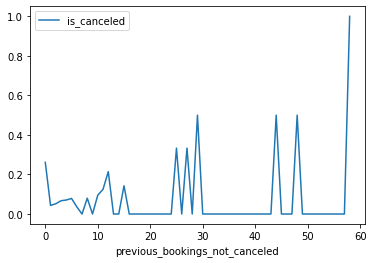

In [21]:
df.pivot_table(index='previous_bookings_not_canceled',values='is_canceled',aggfunc=lambda x:sum(x)/len(x)).plot()

In [22]:
df.loc[df['previous_bookings_not_canceled']>1,'previous_bookings_not_canceled'] = 1

In [23]:
len(df.query('previous_bookings_not_canceled > 1'))

0

In [24]:
len(df.query('previous_bookings_not_canceled == 1'))

1484

In [25]:
df.loc[df['days_in_waiting_list']>10,'days_in_waiting_list'] = df['days_in_waiting_list']/10

<AxesSubplot:>

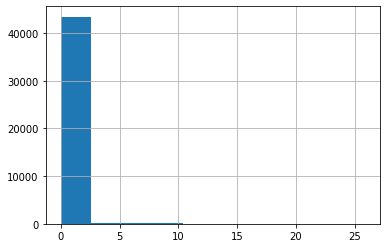

In [26]:
df['days_in_waiting_list'].hist()

In [27]:
df.pivot_table(index='country',values='is_canceled',aggfunc = ('count',lambda x:sum(x)/len(x))).sort_values(by='count',ascending=False)

,<lambda_0>,count
country,,
PRT,0.351559,14467.0
FRA,0.155440,4825.0
GBR,0.167057,4274.0
ESP,0.221853,3908.0
DEU,0.166667,2754.0
...,...,...
NAM,0.000000,1.0
NIC,1.000000,1.0
PLW,0.000000,1.0


In [ ]:
ProfileReport(df)

In [29]:
df.corr()['is_canceled'].abs().sort_values(ascending=False)

is_canceled                       1.000000
previous_cancellations            0.201926
lead_time                         0.176093
required_car_parking_spaces       0.174187
total_of_special_requests         0.134206
previous_bookings_not_canceled    0.085808
booking_changes                   0.080964
total_nights                      0.069679
stays_in_week_nights              0.068193
adults                            0.067246
arrival_date_year                 0.057680
is_repeated_guest                 0.056963
children                          0.041750
stays_in_weekend_nights           0.036411
arrival_date_week_number          0.023653
arrival_date_day_of_month         0.017457
babies                            0.016678
days_in_waiting_list              0.004443
Name: is_canceled, dtype: float64

#### Вывод

Предобработка данных:<br/>
&nbsp;    1)После удаление дубликатов количество объектов - 43 852<br/>
&nbsp;    2)Изменения:<br/>
&nbsp;&nbsp;        а)Пропуски со взрослыми (0 взрослых) заполнены медианным значением.<br/>
&nbsp;&nbsp;        б)Удалены пробелы в типах комнат.<br/>
&nbsp;&nbsp;        в)Были выявлены следующие аномалии: <br/>
&nbsp;&nbsp;&nbsp;         Количество подтвержденных заказов и отмененных:так как значений больше 1 очень мало, им всем присвоено значение 1.<br/>
&nbsp;&nbsp;&nbsp;          Время ожидание подтверждение заказа: значения больше 10 были поделены на 10.<br/>
&nbsp;&nbsp;&nbsp;          Количество изменений параметров заказа: значения не были изменены, так как вполне могли быть реальными (17).<br/>
          
Исследовательский анализ данных:<br/>
&nbsp;Присутствуют множественные корреляции:<br/>
&nbsp;&nbsp;1)Между временными данными<br/>
&nbsp;&nbsp;2)Между столбцами "is_repeated_guest" и "previous_bookings_not_canceled"<br/>

&nbsp;Во многих признаках наблюдается дисбаланс.<br/>

Также можно сразу выявить признаки, которые коррелируют с целевым признаком: <br/>
previous_cancellations-0.2<br/>
lead_time-0.18<br/>
required_car_parking_spaces-0.17<br/>
total_of_special_requests-0.13<br/>
Примечание:в списке учтены только признаки с численными значениями. 

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [30]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [31]:
seasons = {'Summer':['June','July','August'],'Winter':['December','January','February'],'Autumn':['September','October','November'],'Spring':['March','April','May']}

In [32]:
NIGHT_PRICE_TYPES = {'A':1000,'B':800,'C':600,'D':550,'E':500,'F':450,'G':350}
SERVICE_PRICE_TYPES = {'A':400,'B':350,'C':350,'D':150,'E':150,'F':150,'G':150}
SEASON_PRICE = {'Summer':1.4,'Winter':1,'Autumn':1.2,'Spring':1.2}

In [33]:
def apply_season(month):
    for s in seasons:
        if (month in seasons[s]):
            return s
    return 'None'

In [34]:
df['season'] = df['arrival_date_month'].apply(apply_season)

In [35]:
df['season'].unique()

array(['Summer', 'Autumn', 'Winter', 'Spring'], dtype=object)

In [36]:
def calculate_cost(row):
    total_cost = 0
    season = row['season']
    room_type = row['reserved_room_type']
    if (row['is_canceled']==1):
        total_cost -= NIGHT_PRICE_TYPES[room_type]*SEASON_PRICE[season]+SERVICE_PRICE_TYPES[room_type]
        return total_cost
    nights = row['total_nights']
    nights_service = math.floor(nights/2)+1
    nights_cost = nights*NIGHT_PRICE_TYPES[room_type]*SEASON_PRICE[season]
    nights_service_cost = nights_service*SERVICE_PRICE_TYPES[room_type]
    cost = nights_cost-nights_service_cost
    total_cost += cost
    return total_cost

In [37]:
df['profit'] = df.apply(calculate_cost, axis=1)

In [38]:
df.query('is_canceled == 1').iloc[0:1]['profit']

4   -1800.0
Name: profit, dtype: float64

In [39]:
print(f'{sum(df["profit"]):,}')

90,321,219.0


#### Вывод

Функция calculate_cost - расчет прибыли:<br/>
1)если клиент не отменил бронь: стоимость номера за количество ночей, из которой вычитается стоимость уборок, которые происходят каждый второй день.<br/>
2)если клиент отменил бронь: из прибыли вычитается стоимость номера за одну ночь и стоимость одной уборки.<br/>
Примечание: также цены меняются в зависимости от времени года: весной и осенью цены повышаются на 20%, летом — на 40%.<br/>

### Шаг 4. Разработка модели ML

In [40]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'season', 'profit'],
      dtype='object')

In [41]:
features_list = ['lead_time', 'arrival_date_year',
       'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights', 'season']

In [42]:
features_list

['lead_time',
 'arrival_date_year',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'booking_changes',
 'days_in_waiting_list',
 'customer_type',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights',
 'season']

In [43]:
features = df[features_list]
target = df['is_canceled']

In [44]:
features

,lead_time,arrival_date_year,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season
0,7.0,2015,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0.0,Transient,0,0,1,Summer
1,14.0,2015,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0.0,Transient,0,1,2,Summer
2,0.0,2015,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0.0,Transient,0,0,2,Summer
3,9.0,2015,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0.0,Transient,0,1,2,Summer
4,85.0,2015,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0.0,Transient,0,1,3,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43847,23.0,2016,2.0,0.0,0.0,BB,CHN,TA/TO,0,0,0,D,0,0.0,Transient,0,2,6,Winter
43848,53.0,2016,2.0,0.0,0.0,HB,FRA,TA/TO,0,0,0,D,0,0.0,Transient,0,3,5,Winter
43849,7.0,2016,2.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,D,0,0.0,Transient,0,1,6,Winter
43850,17.0,2016,2.0,0.0,0.0,SC,FRA,TA/TO,0,0,0,A,0,0.0,Transient,0,1,7,Winter


In [45]:
ore_list = features_list.copy()
ore_list.remove('lead_time')

In [46]:
features

,lead_time,arrival_date_year,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season
0,7.0,2015,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0.0,Transient,0,0,1,Summer
1,14.0,2015,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0.0,Transient,0,1,2,Summer
2,0.0,2015,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0.0,Transient,0,0,2,Summer
3,9.0,2015,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0.0,Transient,0,1,2,Summer
4,85.0,2015,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0.0,Transient,0,1,3,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43847,23.0,2016,2.0,0.0,0.0,BB,CHN,TA/TO,0,0,0,D,0,0.0,Transient,0,2,6,Winter
43848,53.0,2016,2.0,0.0,0.0,HB,FRA,TA/TO,0,0,0,D,0,0.0,Transient,0,3,5,Winter
43849,7.0,2016,2.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,D,0,0.0,Transient,0,1,6,Winter
43850,17.0,2016,2.0,0.0,0.0,SC,FRA,TA/TO,0,0,0,A,0,0.0,Transient,0,1,7,Winter


In [47]:
ordi = OrdinalEncoder()

test_df = pd.DataFrame(data=ordi.fit_transform(features[ore_list]))
test_df.columns = ore_list
test_df

,arrival_date_year,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season
0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0
1,0.0,1.0,0.0,0.0,0.0,50.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0
2,0.0,1.0,0.0,0.0,0.0,117.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0
3,0.0,1.0,0.0,0.0,1.0,117.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0
4,0.0,1.0,0.0,0.0,0.0,117.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43847,1.0,1.0,0.0,0.0,0.0,26.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,5.0,3.0
43848,1.0,1.0,0.0,0.0,2.0,48.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,3.0,4.0,3.0
43849,1.0,1.0,0.0,0.0,0.0,48.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,5.0,3.0
43850,1.0,1.0,0.0,0.0,4.0,48.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,3.0


#### Выбор метрики

Классы несбалансированы - соотношение количества людей, не отменивших броню к отменившим - 3 к 1.
Поэтому, чтобы правильно определять качество модели, будем считать **F1 метрику**, которая учитывает полноту и точность.

In [48]:
def train_model(features,target,model,tree=False):
    preprocessor = None
    if(tree==False):
        preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['lead_time']),
            ('encoder', OneHotEncoder(sparse=False,handle_unknown='ignore'), ore_list)
        ],remainder='passthrough')
    else:
        preprocessor = ColumnTransformer(
        transformers=[
            ('encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), ore_list)
        ],remainder='passthrough')
    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", model)]
    )
    return cross_val_score(clf, features, target, cv=5,scoring="f1").mean(),model
    

In [49]:
print(f'cross validation F1: {train_model(features,target,LogisticRegression(solver="liblinear"))[0]}')

cross validation F1: 0.37925770107782286


In [50]:
max_score = 0
best_n = 0
best_d = 0
for n in range(1,33,3):
    for d in range(4,44,4):
        score,model = train_model(features,target,RandomForestClassifier(n_estimators=n,max_depth=d,random_state=12345),True)
        if (score>max_score):
            best_n=n
            best_d=d
            max_score=score


In [51]:
print(f'cross validation F1: {max_score}')
print(f'best n:{best_n}')
print(f'best d:{best_d}')

cross validation F1: 0.4293856038785533
best n:4
best d:16


In [52]:
kf = KFold(n_splits=5,shuffle=True,random_state=12345)

In [53]:
preprocessor = ColumnTransformer(
        transformers=[
            ('encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), ore_list)
        ],remainder='passthrough')
features_ore = pd.DataFrame(preprocessor.fit_transform(features))

best_tr = 0
max_score=0
trs = np.arange(0.05,0.55,0.05)
for tr in trs:
    scores=[]
    for train_index, test_index in kf.split(features_ore):
        
        model = RandomForestClassifier(n_estimators=best_n,max_depth=best_d,random_state=12345)
        model.fit(features_ore.iloc[train_index],target.iloc[train_index])
        probs = model.predict_proba(features_ore.iloc[test_index])[:,1]
        predictions_valid = probs>tr
        score = f1_score(target.iloc[test_index],predictions_valid)
        scores.append(score)
    score = sum(scores)/5
    if (score>max_score):
        max_score=score
        best_tr=tr

In [54]:
print(f'cross validation F1: {max_score}')
print(f'best threshold:{best_tr}')

cross validation F1: 0.6209682445961837
best threshold:0.35000000000000003


In [55]:
data_preprocessor = ColumnTransformer(
transformers=[
    ('encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), ore_list)
],remainder='passthrough')

#DATA_PREPROCESSOR.fit(features)

final_model = Pipeline(
        steps=[("preprocessor", data_preprocessor), ("classifier", RandomForestClassifier(n_estimators=best_n,max_depth=best_d,random_state=12345))]
)

In [56]:
final_model.fit(features,target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['arrival_date_year',
                                                   'adults', 'children',
                                                   'babies', 'meal', 'country',
                                                   'distribution_channel',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'reserved_room_type',
                                                   'bo

In [57]:
def prepay(features,target,tr=0.5):
    target = target.reset_index(drop=True)
    probs = final_model.predict_proba(features)[:,1]
    predictions= pd.Series(probs>tr)
    return predictions&target

In [58]:
def prepare_data(data):
    features = data[features_list]
    target = data['is_canceled']
    return features,target

In [59]:
def calculate_cost_prepay(row,tr=0.5):
    total_cost = 0
    
    season = row['season']
    room_type = row['reserved_room_type']
    if (row['prepay']==1):
        total_cost -= ((NIGHT_PRICE_TYPES[room_type])*SEASON_PRICE[season]+SERVICE_PRICE_TYPES[room_type])*0.2
        return total_cost
    if (row['is_canceled']==1):
        total_cost -= NIGHT_PRICE_TYPES[room_type]*SEASON_PRICE[season]+SERVICE_PRICE_TYPES[room_type]
        return total_cost
    nights = row['total_nights']
    nights_service = math.floor(nights/2)+1
    nights_cost = nights*NIGHT_PRICE_TYPES[room_type]*SEASON_PRICE[season]
    nights_service_cost = nights_service
    total_cost = nights_cost-nights_service_cost
    return total_cost

#### Вывод

Лучшие результаты показала модель: RandomForestClassifier со следующими гипперпараметрами: n_estimators-4,max_depth-16<br/>
Порог примерно равен соотношению классов в тренировочной выборке 1 к 3 - 0.3.<br/>
Результаты:<br/>
F1-0.62<br/>

#### Подготовка тестовых данных

In [60]:
test_df = pd.read_csv('/datasets/hotel_test.csv',index_col='id')

In [61]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32412 entries, 6086 to 97903
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     32412 non-null  int64  
 1   lead_time                       32412 non-null  float64
 2   arrival_date_year               32412 non-null  int64  
 3   arrival_date_month              32412 non-null  object 
 4   arrival_date_week_number        32412 non-null  int64  
 5   arrival_date_day_of_month       32412 non-null  int64  
 6   stays_in_weekend_nights         32412 non-null  int64  
 7   stays_in_week_nights            32412 non-null  int64  
 8   adults                          32412 non-null  float64
 9   children                        32412 non-null  float64
 10  babies                          32412 non-null  float64
 11  meal                            32412 non-null  object 
 12  country                      

In [62]:
test_df = test_df.drop_duplicates()
test_df['reserved_room_type']= test_df['reserved_room_type'].str.strip()
test_df['country']= test_df['country'].str.strip()
test_df['adults'] = test_df['adults'].replace(0,test_df['adults'].median())
test_df.loc[test_df['previous_bookings_not_canceled']>1,'previous_bookings_not_canceled'] = 1
test_df.loc[test_df['previous_cancellations']>1,'previous_cancellations'] = 1
test_df.loc[test_df['days_in_waiting_list']>10,'days_in_waiting_list'] = test_df['days_in_waiting_list']/10

In [63]:
test_df['season'] = test_df['arrival_date_month'].apply(apply_season)

In [ ]:
ProfileReport(test_df)

In [65]:
df.drop('profit',axis=1).describe().compare(test_df.describe())

is_canceled                   lead_time                \
               self         other          self         other   
count  43852.000000  24695.000000  43852.000000  24695.000000   
mean       0.254219      0.315246     67.893779     88.834541   
std        0.435426      0.464623     73.990715     85.506551   
min             NaN           NaN           NaN           NaN   
25%             NaN           NaN      9.000000     16.000000   
50%             NaN           NaN     41.000000     63.000000   
75%             NaN           NaN    103.000000    143.000000   
max             NaN           NaN    374.000000    373.000000   

      arrival_date_year          arrival_date_week_number                \
                   self    other                     self         other   
count      43852.000000  24695.0             43852.000000  24695.000000   
mean        2015.775518   2017.0                31.091216     18.192833   
std            0.417246      0.0                13.894327      9.438886   
min         2015.000000   2017.0                      NaN           NaN   
25%         2016.000000   2017.0                20.000000     10.000000   
50%         2016.000000   2017.0                33.000000     18.000000   
75%         2016.000000   2017.0                43.000000     26.000000   
max         2016.000000   2017.0                53.000000     35.000000   

      arrival_date_day_of_month                ... booking_changes  \
                           self         other  ...            self   
count              43852.000000  24695.000000  ...    43852.000000   
mean                  15.919274     15.579348  ...        0.249453   
std                    8.859208      8.776695  ...        0.679791   
min                         NaN           NaN  ...             NaN   
25%                         NaN           NaN  ...             NaN   
50%                   16.000000     15.000000  ...             NaN   
75%                   24.000000     23.000000  ...             NaN   
max                         NaN           NaN  ...       17.000000   

                    days_in_waiting_list                \
              other                 self         other   
count  24695.000000         43852.000000  24695.000000   
mean       0.254343             0.085563      0.039360   
std        0.698303             1.002407      0.573469   
min             NaN                  NaN           NaN   
25%             NaN                  NaN           NaN   
50%             NaN                  NaN           NaN   
75%             NaN                  NaN           NaN   
max       18.000000            25.900000     22.300000   

      required_car_parking_spaces               total_of_special_requests  \
                             self         other                      self   
count                43852.000000  24695.000000              43852.000000   
mean                     0.082368      0.059567                  0.670847   
std                      0.276086      0.247559                  0.802964   
min                           NaN           NaN                       NaN   
25%                           NaN           NaN                       NaN   
50%                           NaN           NaN                  0.000000   
75%                           NaN           NaN                       NaN   
max                      3.000000      8.000000                       NaN   

                     total_nights                
              other          self         other  
count  24695.000000  43852.000000  24695.000000  
mean       0.763272      3.208155      3.289492  
std        0.861233      1.877202      1.818364  
min             NaN           NaN           NaN  
25%             NaN           NaN           NaN  
50%        1.000000           NaN           NaN  
75%             NaN           NaN           NaN  
max             NaN           NaN           NaN  

[8 rows x 36 columns]

In [66]:
features_test,target_test = prepare_data(test_df)
test_df['prepay']=list(prepay(features_test,target_test,best_tr))

In [91]:
probs = final_model.predict_proba(features_test)[:,1]
predictions_test = probs>best_tr
print(f'f1: {f1_score(target_test,predictions_test)}')

f1: 0.37983942908117757


In [68]:
test_df['profit_prepay']=test_df.apply(calculate_cost_prepay,axis=1)
test_df['profit']=test_df.apply(calculate_cost,axis=1)

In [69]:
sum(test_df['profit'])

44976654.0

In [70]:
sum(test_df['profit_prepay'])

47326894.0

In [71]:
sum(test_df['profit_prepay'])-sum(test_df['profit'])

2350240.0

In [72]:
test_df['prepay']=list(prepay(features_test,target_test,0.5))
test_df['profit_prepay']=test_df.apply(calculate_cost_prepay,axis=1)
test_df['profit']=test_df.apply(calculate_cost,axis=1)

In [73]:
sum(test_df['profit_prepay'])-sum(test_df['profit'])

1447600.0

In [74]:
probs = final_model.predict_proba(features_test)[:,1]
predictions= pd.Series(probs>best_tr)
target_test = target_test.reset_index(drop=True)


In [75]:
print(sum((predictions==1)&(target_test==0))/sum(target_test==0))

0.07664104080425783


In [76]:
print(sum((predictions==1)&(target_test==1))/sum(target_test==1))

0.2734746307000642


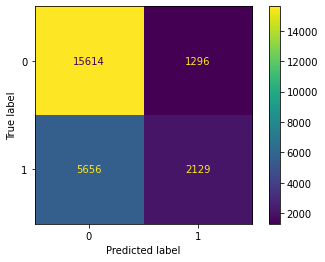

In [77]:
c_m = confusion_matrix(target_test,predictions)
disp = ConfusionMatrixDisplay(c_m)
disp.plot()

In [78]:
probs = final_model.predict_proba(features_test)[:,1]
predictions= pd.Series(probs>0.5)
target_test = target_test.reset_index(drop=True)
print(sum((predictions==1)&(target_test==0))/sum(target_test==0))
print(sum((predictions==1)&(target_test==1))/sum(target_test==1))

0.03293908929627439
0.16005138086062942


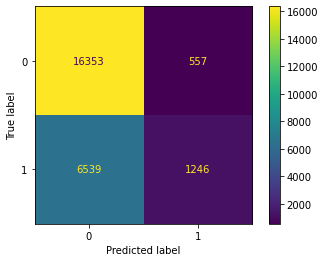

In [79]:
c_m = confusion_matrix(target_test,predictions)
disp = ConfusionMatrixDisplay(c_m)
disp.plot()

#### Вывод

Прибыль компании за год:<br/>
1)Без внедрения депозитов: 44 976 654<br/>
2)С внедрением депозитов: 47 326 894<br/>
Разница: 2 350 240<br/>
Доля клиентов, которые после использования модели внесли депозит и отказались от брони - 0.27<br/>
Доля клиентов, которые после использования модели внесли депозит и не отказались от брони - 0.08<br/>

**Следовательно модель окупает свою разработку - 400 000**. При этом присутсвует 8% людей, которые внесли депозит и при этом не отказываются от брони. В дальнейшем, это может отпугнуть будущих клиентов, так как исходя из описания проекта для привлечения клиентов отель ввел возможность брони без предоплаты. Для решения этой проблемы можно повысить порог, тем самым уменьшить качество модели, что в свою очередь повлечет снижение прибыли в годовом периоде, но из-за меньшей доли "надежных" клиентов, которым требуется внести депозит, в долгосрочной перспективе (2-5 лет) можно принести большую прибыль. Также стоит учитывать репутационные риски.

К примеру, при использовании порога - 0.5 разница в прибыли составила 1 447 600, при этом:<br/>
Доля клиентов, которые после использования модели внесли депозит и отказались от брони - 0.16<br/>
Доля клиентов, которые после использования модели внесли депозит и не отказались от брони - 0.03<br/>

### Шаг 5. Портрет «ненадёжного» клиента

In [80]:
df.query('is_canceled == 0').describe().compare(df.query('is_canceled == 1').describe())['total_of_special_requests']

,self,other
count,32704.000000,11148.000000
mean,0.733763,0.486276
std,0.813850,0.739927
min,NaN,NaN
25%,NaN,NaN
50%,1.000000,0.000000
75%,NaN,NaN
max,5.000000,4.000000


In [81]:
test_df.query('is_canceled == 0').describe().compare(test_df.query('is_canceled == 1').describe())

is_canceled             lead_time              arrival_date_year  \
             self   other          self        other              self   
count     16910.0  7785.0  16910.000000  7785.000000           16910.0   
mean          0.0     1.0     75.869072   116.997174               NaN   
std           NaN     NaN     80.086818    90.019121               NaN   
min           0.0     1.0           NaN          NaN               NaN   
25%           0.0     1.0      9.000000    39.000000               NaN   
50%           0.0     1.0     46.000000    99.000000               NaN   
75%           0.0     1.0    124.000000   176.000000               NaN   
max           0.0     1.0    368.000000   373.000000               NaN   

              arrival_date_week_number              arrival_date_day_of_month  \
        other                     self        other                      self   
count  7785.0             16910.000000  7785.000000              16910.000000   
mean      NaN                17.774276    19.101991                 15.651804   
std       NaN                 9.494004     9.253642                  8.793293   
min       NaN                      NaN          NaN                       NaN   
25%       NaN                10.000000    12.000000                       NaN   
50%       NaN                18.000000    19.000000                 16.000000   
75%       NaN                26.000000    27.000000                       NaN   
max       NaN                      NaN          NaN                       NaN   

                    ... required_car_parking_spaces          \
             other  ...                        self   other   
count  7785.000000  ...                16910.000000  7785.0   
mean     15.421965  ...                    0.086990     0.0   
std       8.739028  ...                    0.295154     0.0   
min            NaN  ...                         NaN     NaN   
25%            NaN  ...                         NaN     NaN   
50%      15.000000  ...                         NaN     NaN   
75%            NaN  ...                         NaN     NaN   
max            NaN  ...                    8.000000     0.0   

      total_of_special_requests              total_nights               \
                           self        other         self        other   
count              16910.000000  7785.000000  16910.00000  7785.000000   
mean                   0.833590     0.610533      3.17948     3.528452   
std                    0.887608     0.779452      1.82770     1.774692   
min                         NaN          NaN          NaN          NaN   
25%                         NaN          NaN          NaN          NaN   
50%                    1.000000     0.000000          NaN          NaN   
75%                         NaN          NaN          NaN          NaN   
max                         NaN          NaN          NaN          NaN   

      profit_prepay                     profit               
               self        other          self        other  
count  16910.000000  7785.000000  16910.000000  7785.000000  
mean    3284.945240 -1172.019268   3284.945240 -1357.966602  
std     2137.896475   543.108095   2137.896475   414.881252  
min      349.000000 -1800.000000    349.000000 -1800.000000  
25%     1399.000000 -1600.000000   1399.000000 -1800.000000  
50%     2798.000000 -1400.000000   2798.000000 -1600.000000  
75%     4198.000000  -750.000000   4198.000000  -920.000000  
max    13994.000000  -100.000000  13994.000000  -500.000000  

[8 rows x 40 columns]

In [82]:
final_model.steps[1][1].feature_importances_

array([0.04532131, 0.02597239, 0.0173457 , 0.00255427, 0.03473486,
       0.15742754, 0.03999255, 0.00590674, 0.06831391, 0.01386323,
       0.03695011, 0.04050333, 0.00278037, 0.05492036, 0.05024969,
       0.09106979, 0.05895992, 0.03860656, 0.21452736])

In [83]:
features_post_list = ore_list.copy()
features_post_list.append('lead_time')

In [84]:
features_post_list

['arrival_date_year',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'booking_changes',
 'days_in_waiting_list',
 'customer_type',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights',
 'season',
 'lead_time']

In [85]:
df.corr()['is_canceled'].abs().sort_values(ascending=False)

is_canceled                       1.000000
profit                            0.732630
previous_cancellations            0.201926
lead_time                         0.176093
required_car_parking_spaces       0.174187
total_of_special_requests         0.134206
previous_bookings_not_canceled    0.085808
booking_changes                   0.080964
total_nights                      0.069679
stays_in_week_nights              0.068193
adults                            0.067246
arrival_date_year                 0.057680
is_repeated_guest                 0.056963
children                          0.041750
stays_in_weekend_nights           0.036411
arrival_date_week_number          0.023653
arrival_date_day_of_month         0.017457
babies                            0.016678
days_in_waiting_list              0.004443
Name: is_canceled, dtype: float64

In [86]:
df.query('is_canceled == 1')['required_car_parking_spaces'].unique()

array([0])

In [87]:
df.pivot_table(index='country',values='is_canceled',aggfunc = ('count',lambda x:sum(x)/len(x))).sort_values(by='count',ascending=False)

,<lambda_0>,count
country,,
PRT,0.351559,14467.0
FRA,0.155440,4825.0
GBR,0.167057,4274.0
ESP,0.221853,3908.0
DEU,0.166667,2754.0
...,...,...
NAM,0.000000,1.0
NIC,1.000000,1.0
PLW,0.000000,1.0


In [88]:
pd.Series(final_model.steps[1][1].feature_importances_,index=features_post_list).sort_values(ascending=False)

lead_time                         0.214527
country                           0.157428
total_of_special_requests         0.091070
previous_cancellations            0.068314
total_nights                      0.058960
customer_type                     0.054920
required_car_parking_spaces       0.050250
arrival_date_year                 0.045321
booking_changes                   0.040503
distribution_channel              0.039993
season                            0.038607
reserved_room_type                0.036950
meal                              0.034735
adults                            0.025972
children                          0.017346
previous_bookings_not_canceled    0.013863
is_repeated_guest                 0.005907
days_in_waiting_list              0.002780
babies                            0.002554
dtype: float64

In [89]:
df.pivot_table(index='total_nights',values='is_canceled',aggfunc= ('count',lambda x:sum(x)/len(x)))

,<lambda_0>,count
total_nights,,
1,0.181109,9359.0
2,0.258706,8442.0
3,0.275228,9632.0
4,0.275915,7216.0
5,0.269241,3599.0
6,0.320696,1609.0
7,0.277439,3280.0
8,0.322851,477.0
9,0.330645,124.0


In [90]:
df.pivot_table(index='customer_type',values='is_canceled',aggfunc= ('count',lambda x:sum(x)/len(x)))

,<lambda_0>,count
customer_type,,
Contract,0.197439,1874.0
Group,0.073359,259.0
Transient,0.273403,35369.0
Transient-Party,0.171496,6350.0


Исходя из результатов работы модели и корреляционной матрицы, можно выявить следующие признаки, которые могут охарактеризовать "ненадежного" клиента:

lead time - чем больше времени между бронированием и преездом, тем выше шанс, что человек откажется от брони. Среднее время среди людей без отказа - 60, среди людей, которые отказались - 90.<br/>

required_car_parking_spaces - если человеку необходимо место для автомобиля, то он точно не откажется от брони.<br/>

previous_cancellations - чем больше у человека было отказов, тем выше шанс, что человек еще раз откажется от брони. Среднее значение среди людей с отказом в 10 раз выше, чем среди людей без отказа (0.08 и 0.07)<br/>

country - гражднаство человека влияет на отказ от брони. К примеру, если человек - гражданин Португалии, то шанс, что он откажется от брони в 2 раза выше чем среди граждан Франции<br/>

total_of_special_requests - чем меньше количество специальных отметок, тем выше шанс, что человек откажется от брони. Среднее значение среди людей с отказом в 1.5 раз меньше, чем среди людей без отказа (0.73 и 0.49)<br/>

total_nights - с увеличением количества ночей, растет доля людей, отказавшихся от брони. К примеру: доля людей, у которых бронь на 2 ночи: 26%, на 5 ночей - 27%.

customer_type - тип заказчика влияет на вероятность отказа от брони. Так, среди типа Transient — не связано с договором или групповым заездом, доля людей, отказавшихся от брони - 27%. Доля людей с типом Contract - договор с юридическим лицом, отказавшися от брони - 20%

**Портрет «ненадёжного» клиента:**<br/>
&nbsp;1)время между бронированием и преездом примерно 90<br/>
&nbsp;2)не требуется место для автомобиля<br/>
&nbsp;3)гражданство-Португалия<br/>
&nbsp;4)как минимум 1 отмененная бронь<br/>
&nbsp;5)количество специальных отметок меньше 2<br/>
&nbsp;5)6 и более ночей<br/>
&nbsp;5)тип заказчика - Transient<br/>

#### Вывод

Результаты проведенного исследования:<br/>
<br/>
Лучшие результаты показала модель: RandomForestClassifier со следующими гипперпараметрами: n_estimators-4,max_depth-16<br/>
Порог примерно равен соотношению классов в тренировочной выборке 1 к 3 - 0.3.<br/>
Результаты:<br/>
F1-0.61<br/>
F1 на тестовой выборке -0.61<br/>

Прибыль компании за год:<br/>
1)Без внедрения депозитов: 44 976 654<br/>
2)С внедрением депозитов: 47 326 894<br/>
Разница: 2 350 240<br/>
Доля клиентов, которые после использования модели внесли депозит и отказались от брони - 0.27<br/>
Доля клиентов, которые после использования модели внесли депозит и не отказались от брони - 0.08<br/>

**Следовательно модель окупает свою разработку - 400 000**. При этом присутсвует 8% людей, которые внесли депозит и при этом не отказываются от брони. В дальнейшем, это может отпугнуть будущих клиентов, так как исходя из описания проекта для привлечения клиентов отель ввел возможность брони без предоплаты. Для решения этой проблемы можно повысить порог, тем самым уменьшить качество модели, что в свою очередь повлечет снижение прибыли в годовом периоде, но из-за меньшей доли "надежных" клиентов, которым требуется внести депозит, в долгосрочной перспективе (2-5 лет) можно принести большую прибыль. Также стоит учитывать репутационные риски.

К примеру, при использовании порога - 0.5 разница в прибыли составила 1 447 600, при этом:<br/>
Доля клиентов, которые после использования модели внесли депозит и отказались от брони - 0.16<br/>
Доля клиентов, которые после использования модели внесли депозит и не отказались от брони - 0.03<br/>

Рекомендация: для решения этой проблемы можно повысить порог, тем самым уменьшить качество модели, что в свою очередь повлечет снижение прибыли в годовом периоде, но из-за меньшей доли "надежных" клиентов, которым требуется внести депозит, в долгосрочной перспективе (2-5 лет) можно принести большую прибыль, так как возможно увеличение количества клиентов.
Стоит провести анализ изменения количества клиентов после внедрения модели с заданным порогом (к примеру, 0.5).<br/>
Общие рекомендации: увеличить выборку, увеличить количество признаков, использовать другие модели машинного обучения, объяснить причину аномалий и по необходимости провести повторный анализ.<br/>

Исходя из работы модели:<br/>
**Портрет «ненадёжного» клиента:**<br/>
&nbsp;1)время между бронированием и преездом примерно 90<br/>
&nbsp;2)не требуется место для автомобиля<br/>
&nbsp;3)гражданство-Португалия<br/>
&nbsp;4)как минимум 1 отмененная бронь<br/>
&nbsp;5)количество специальных отметок меньше 2<br/>
&nbsp;6)6 и более ночей<br/>
&nbsp;7)тип заказчика - Transient<br/>